In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import numpy as np
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/zixuanzhang/miniconda3/envs/jaxqtl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.0 scikit-learn==1.2.2 statsmodels==0.14.0rc0 pynndescent==0.5.8


In [2]:
pheno_path = "../../jaxqtl_project/data/OneK1K/pheno/OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz"

In [3]:
mat = sc.read_h5ad(pheno_path)
mat

AnnData object with n_obs × n_vars = 1272489 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

In [4]:
to_rm = ['Erythrocytes', 'Platelets']
mat=mat[~mat.obs.cell_label.isin(to_rm), :]
mat.obs.cell_label.unique().to_list()

['CD4 ET',
 'NK',
 'CD4 NC',
 'CD8 S100B',
 'CD8 ET',
 'B IN',
 'CD8 NC',
 'B Mem',
 'NK R',
 'Mono NC',
 'Mono C',
 'DC',
 'Plasma',
 'CD4 SOX4']

In [5]:
# check uniqueness of gene_id (ensembl_id)
print(len(mat.var.index) == len(mat.var.index.unique()))
mat

True


View of AnnData object with n_obs × n_vars = 1267768 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

In [11]:
mat.var # Geneid

,GeneSymbol,features
Geneid,,
ENSG00000243485,MIR1302-10,MIR1302-10
ENSG00000237613,FAM138A,FAM138A
ENSG00000186092,OR4F5,OR4F5
ENSG00000238009,RP11-34P13.7,RP11-34P13.7
ENSG00000239945,RP11-34P13.8,RP11-34P13.8
...,...,...
ENSG00000215635,AC145205.1,AC145205.1
ENSG00000268590,BAGE5,BAGE5
ENSG00000251180,CU459201.1,CU459201.1


/Users/zixuanzhang/miniconda3/envs/jaxqtl/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:45)


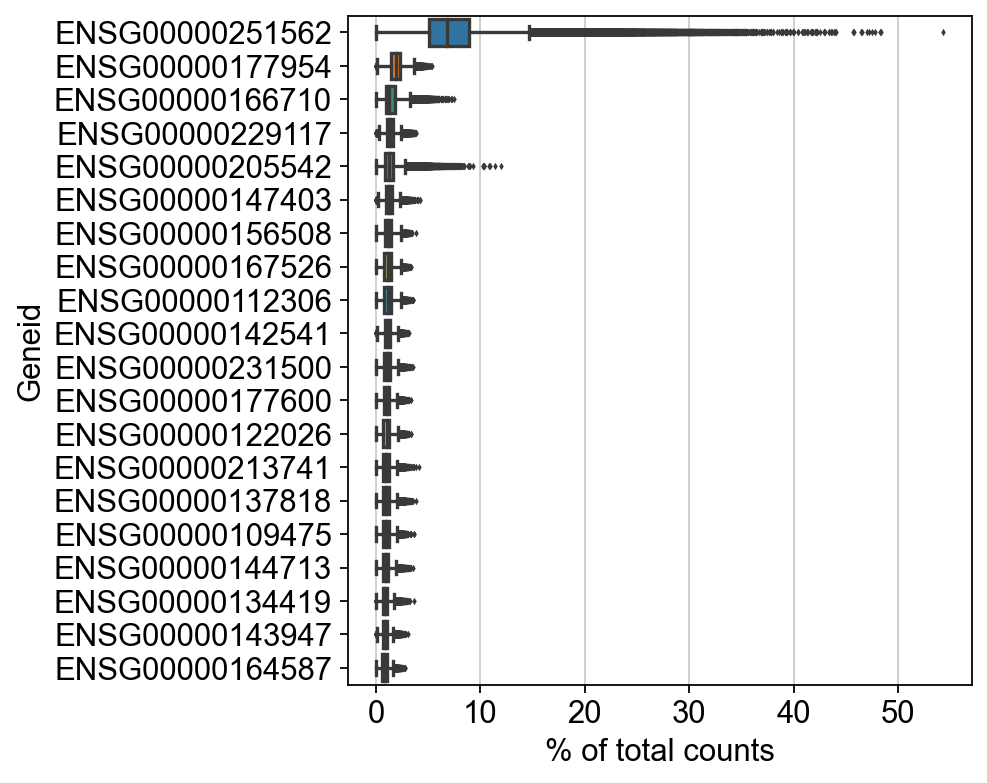

In [12]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(mat, n_top=20, )
# observe the "usual suspect" MALAT1 (ENSG00000251562)
# ref: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.highest_expr_genes.html#scanpy.pl.highest_expr_genes

# Assess quality

In [ ]:
# doublet were removed in the raw dataset

## Cell count

In [6]:
# cell count per individual
cell_per_ind = mat.obs.groupby(['individual']).size().reset_index(name='counts')
cell_per_celltype_ind = mat.obs.groupby(['individual', 'cell_label']).size().reset_index(name='counts')
cell_per_celltype = mat.obs.groupby(['cell_label']).size().reset_index(name='counts')

In [7]:
# 870_871 should be labeled as 966_967
cell_per_ind[cell_per_ind.individual.isin(['88_88', '966_967', '870_871'])]

,individual,counts
72,88_88,1305
787,870_871,1691


In [9]:
print(cell_per_ind.loc[cell_per_ind.counts == cell_per_ind.counts.min()])
print(cell_per_ind.loc[cell_per_ind.counts == cell_per_ind.counts.max()])

    individual  counts
166    193_194     342
    individual  counts
588    650_651    3501


In [ ]:
cell_per_celltype_ind[cell_per_celltype_ind.individual.isin(['88_88', '966_967', '870_871'])]

In [13]:
mat.obs.loc[mat.obs.individual == '870_871',]

,orig.ident,nCount_RNA,nFeature_RNA,pool,individual,percent.mt,latent,nCount_SCT,nFeature_SCT,cell_type,cell_label,sex,age
barcode,,,,,,,,,,,,,
AAACCTGTCCTGCCAT-19,0,5084.0,1585,18,870_871,4.661684,0,3381.0,1558,14,NK,2,71
AAAGATGCAACACCTA-19,0,1758.0,738,18,870_871,1.308305,0,2525.0,740,14,NK,2,71
AAAGTAGGTCGGATCC-19,0,1040.0,498,18,870_871,3.750000,0,2502.0,537,9,Mono C,2,71
AACTGGTAGATATGCA-19,0,1025.0,443,18,870_871,2.243902,0,2569.0,478,3,CD8 ET,2,71
AAGGAGCAGGCCCTCA-19,0,2411.0,933,18,870_871,3.566985,0,2692.0,933,14,NK,2,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTGATTCT-38,0,1030.0,455,37,870_871,2.330097,1,2562.0,497,3,CD8 ET,2,71
TTTGTCAAGGATGGAA-38,0,4437.0,1215,37,870_871,1.915709,1,3222.0,1211,1,CD4 ET,2,71
TTTGTCAAGGCACATG-38,0,1210.0,475,37,870_871,3.884298,1,2648.0,490,14,NK,2,71


count     981.000000
mean     1292.322120
std       322.309913
min       342.000000
25%      1092.000000
50%      1266.000000
75%      1463.000000
max      3501.000000
Name: counts, dtype: float64


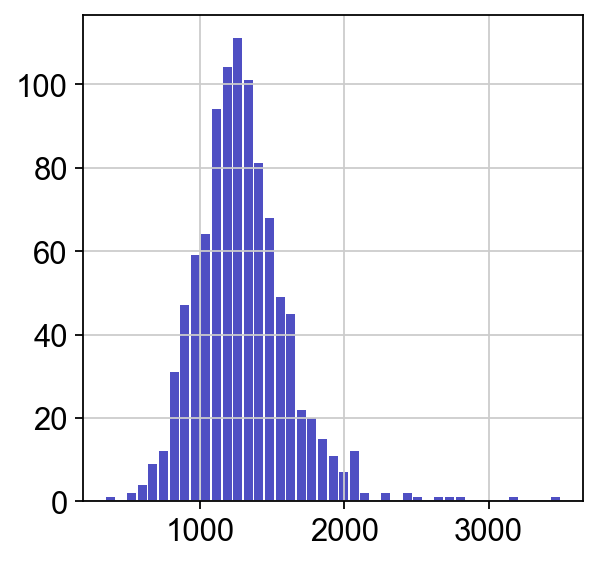

In [16]:
# cell count per individual
# The cell counts are determined by the number of unique cellular barcodes detected.
plt_n, plt_bins, plt_patches = plt.hist(x=cell_per_ind['counts'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
print(cell_per_ind.counts.describe())

<BarContainer object of 14 artists>

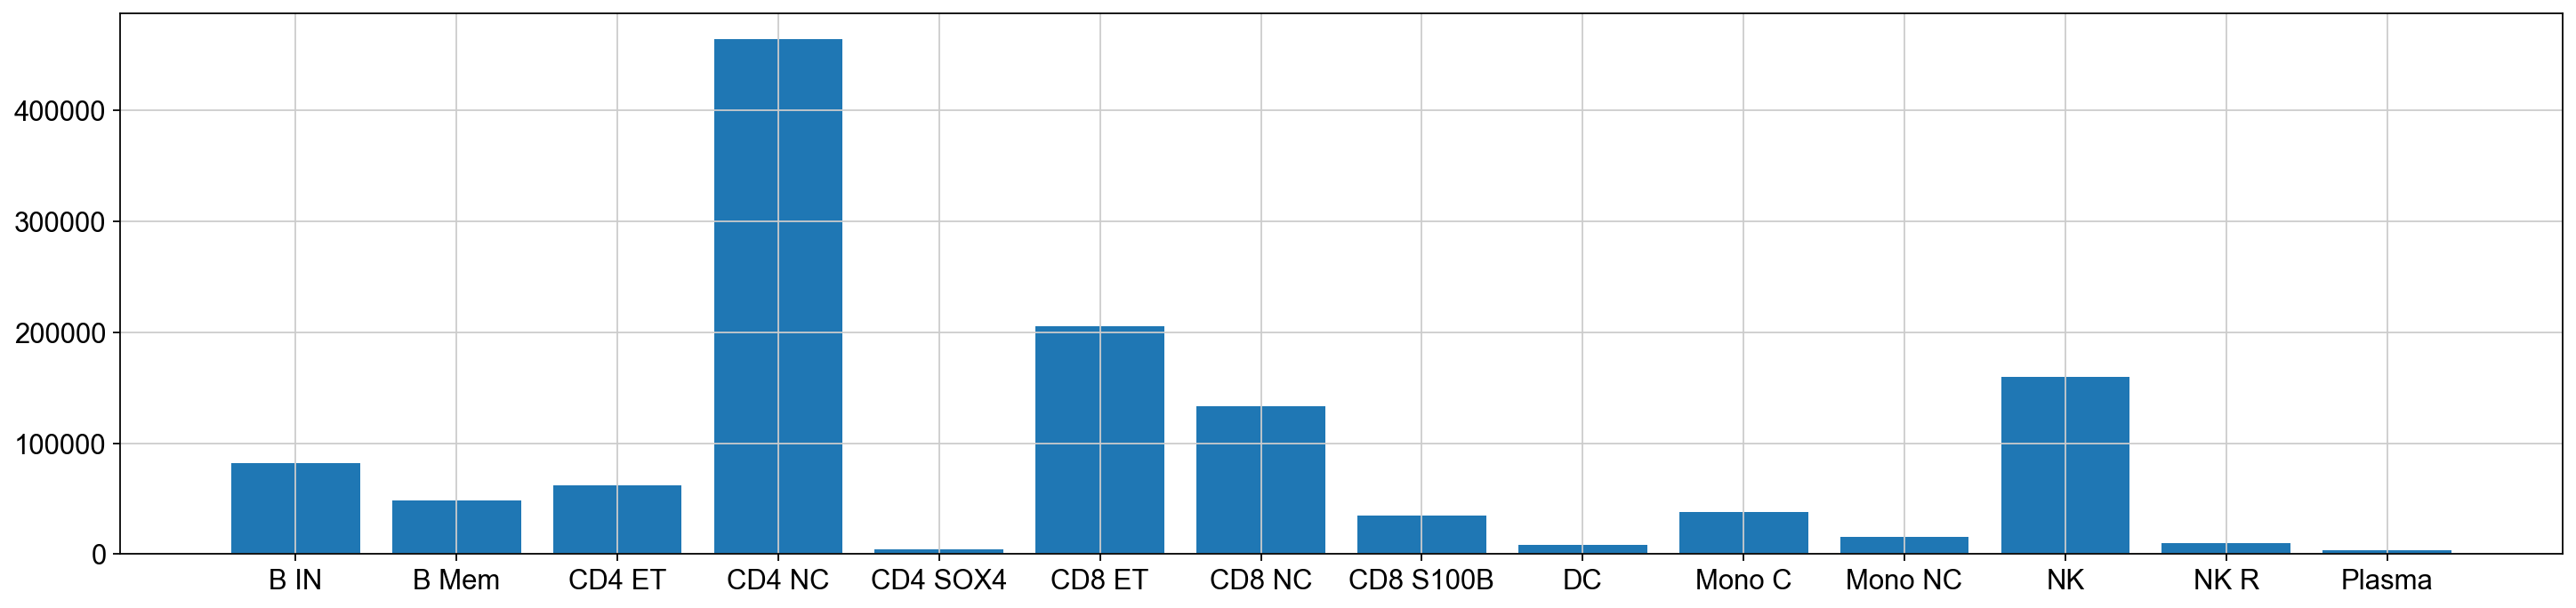

In [19]:
# cell count 
plt.figure(figsize=(22, 5))
plt.bar(cell_per_celltype['cell_label'], cell_per_celltype['counts'])

## UMI count per cell

count    1.267768e+06
mean     3.291844e+03
std      1.921567e+03
min      6.620000e+02
25%      1.996000e+03
50%      2.868000e+03
75%      4.106000e+03
max      8.289200e+04
Name: nCount_RNA, dtype: float64


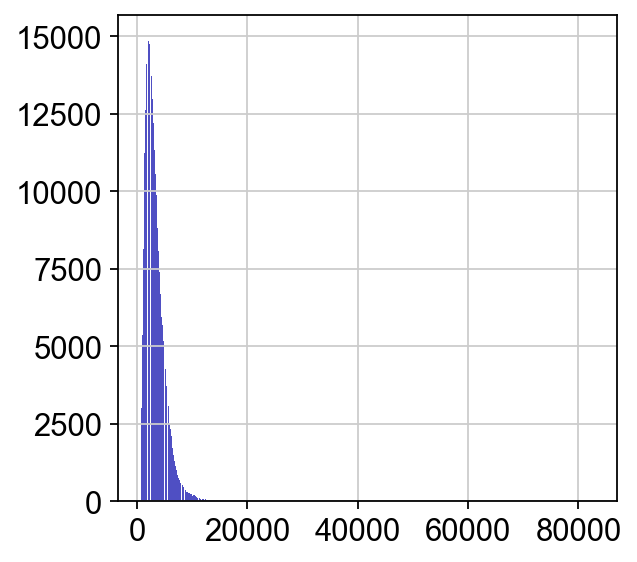

In [29]:
# expect > 500
print(mat.obs.nCount_RNA.describe()) 
plt_n, plt_bins, plt_patches = plt.hist(x=mat.obs['nCount_RNA'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
# consider remove cells with > mean + 3*SD

## Genes per cell

count    1.267768e+06
mean     9.156476e+02
std      3.649885e+02
min      1.930000e+02
25%      6.620000e+02
50%      8.540000e+02
75%      1.095000e+03
max      6.927000e+03
Name: nFeature_RNA, dtype: float64


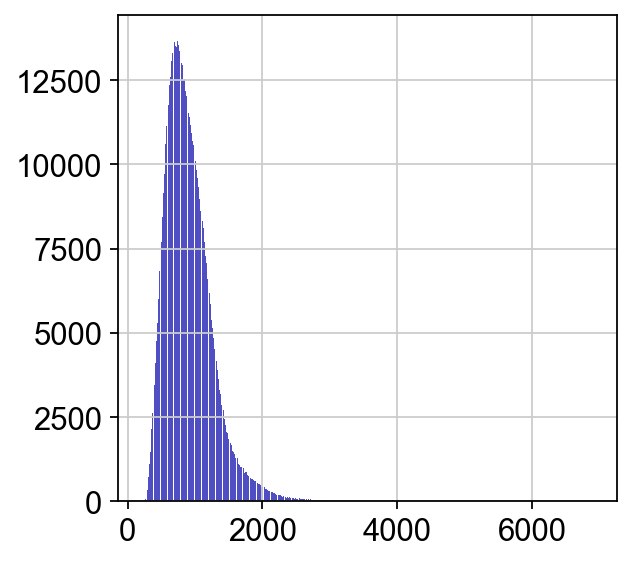

In [30]:
# number of genes expressed per cell > 100
# nFeature_RNA: the number of genes detected in each cell. 
# nCount_RNA: the total number of molecules (UMI) detected within a cell.
print(mat.obs.nFeature_RNA.describe()) 
plt_n, plt_bins, plt_patches = plt.hist(x=mat.obs['nFeature_RNA'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [28]:
mat[mat.obs.nFeature_RNA>2500,:]

View of AnnData object with n_obs × n_vars = 5015 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

## UMIs vs. Genes per cell

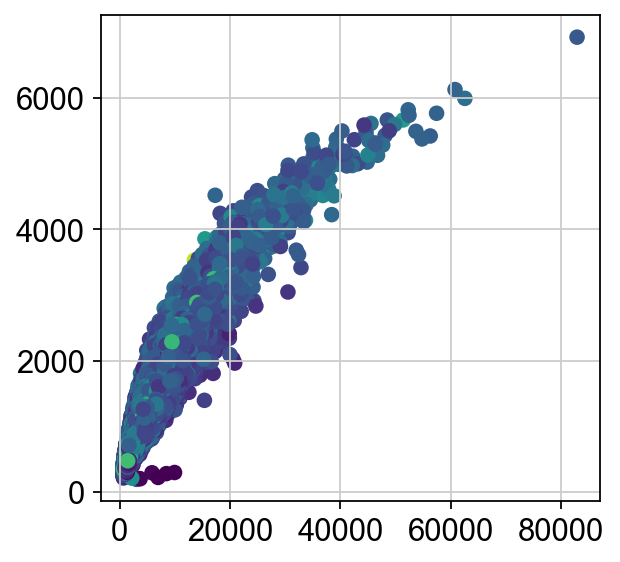

In [33]:
# poor quality are likely to have low genes and UMIs per cell
plt.scatter(mat.obs['nCount_RNA'], mat.obs['nFeature_RNA'], c=mat.obs['percent.mt'])

## Mitochondria count

count    1.272489e+06
mean     3.209758e+00
std      1.350741e+00
min      3.013258e-02
25%      2.252724e+00
50%      2.990773e+00
75%      3.929385e+00
max      1.093633e+01
Name: percent.mt, dtype: float64


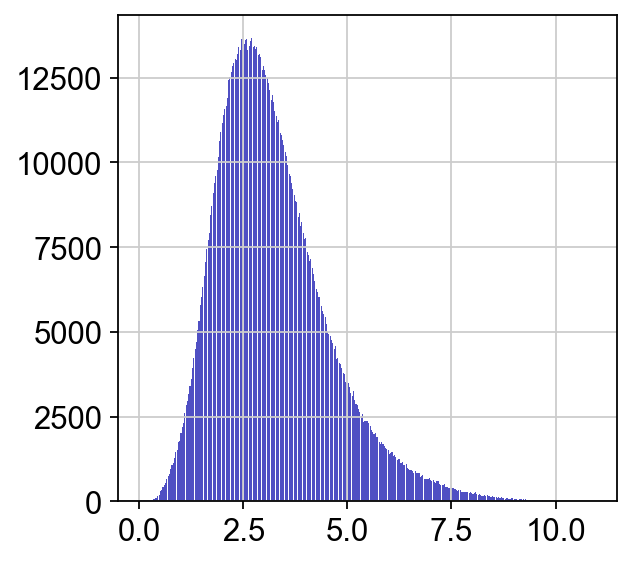

In [56]:
# This metric can identify whether there is a large amount of mitochondrial contamination from dead or dying cells.
# The threshold is usually 5%
print(mat.obs['percent.mt'].describe())
plt_n, plt_bins, plt_patches = plt.hist(x=mat.obs['percent.mt'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

## Complexity

In [34]:
# Add number of genes per UMI for each cell to metadata
log10GenesPerUMI = np.log10(mat.obs['nFeature_RNA']) / np.log10(mat.obs['nCount_RNA'])

count    1.267768e+06
mean     8.485951e-01
std      2.358136e-02
min      6.104660e-01
25%      8.307451e-01
50%      8.460671e-01
75%      8.648547e-01
max      9.392843e-01
dtype: float64


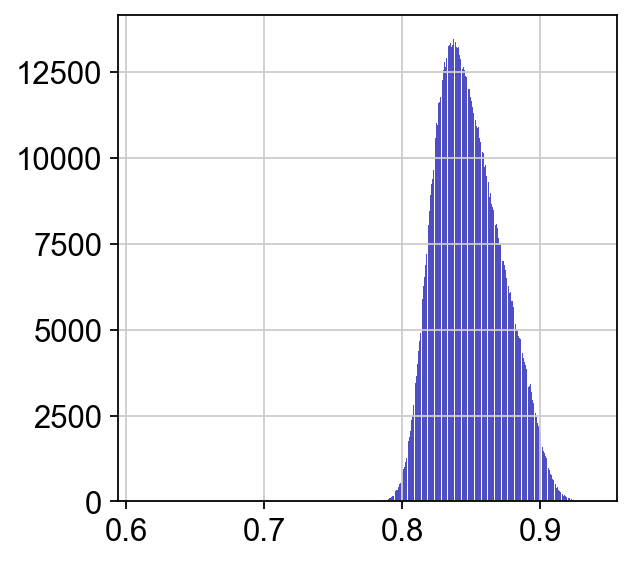

In [35]:
# Generally, we expect the novelty score to be above 0.80
print(log10GenesPerUMI.describe())
plt_n, plt_bins, plt_patches = plt.hist(x=log10GenesPerUMI, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [16]:
# Keep cells with >= 200 genes expressed
# sc.pp.filter_cells(mat, min_genes=200)

# Keep genes that are expressed in >= 3 cells
# sc.pp.filter_genes(mat, min_cells=3)

In [41]:
mat.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000237683',
       'ENSG00000239906', 'ENSG00000241599', 'ENSG00000228463',
       'ENSG00000237094',
       ...
       'ENSG00000217792', 'ENSG00000268276', 'ENSG00000148828',
       'ENSG00000215700', 'ENSG00000215699', 'ENSG00000215635',
       'ENSG00000268590', 'ENSG00000251180', 'ENSG00000215616',
       'ENSG00000215611'],
      dtype='object', name='Geneid', length=32738)

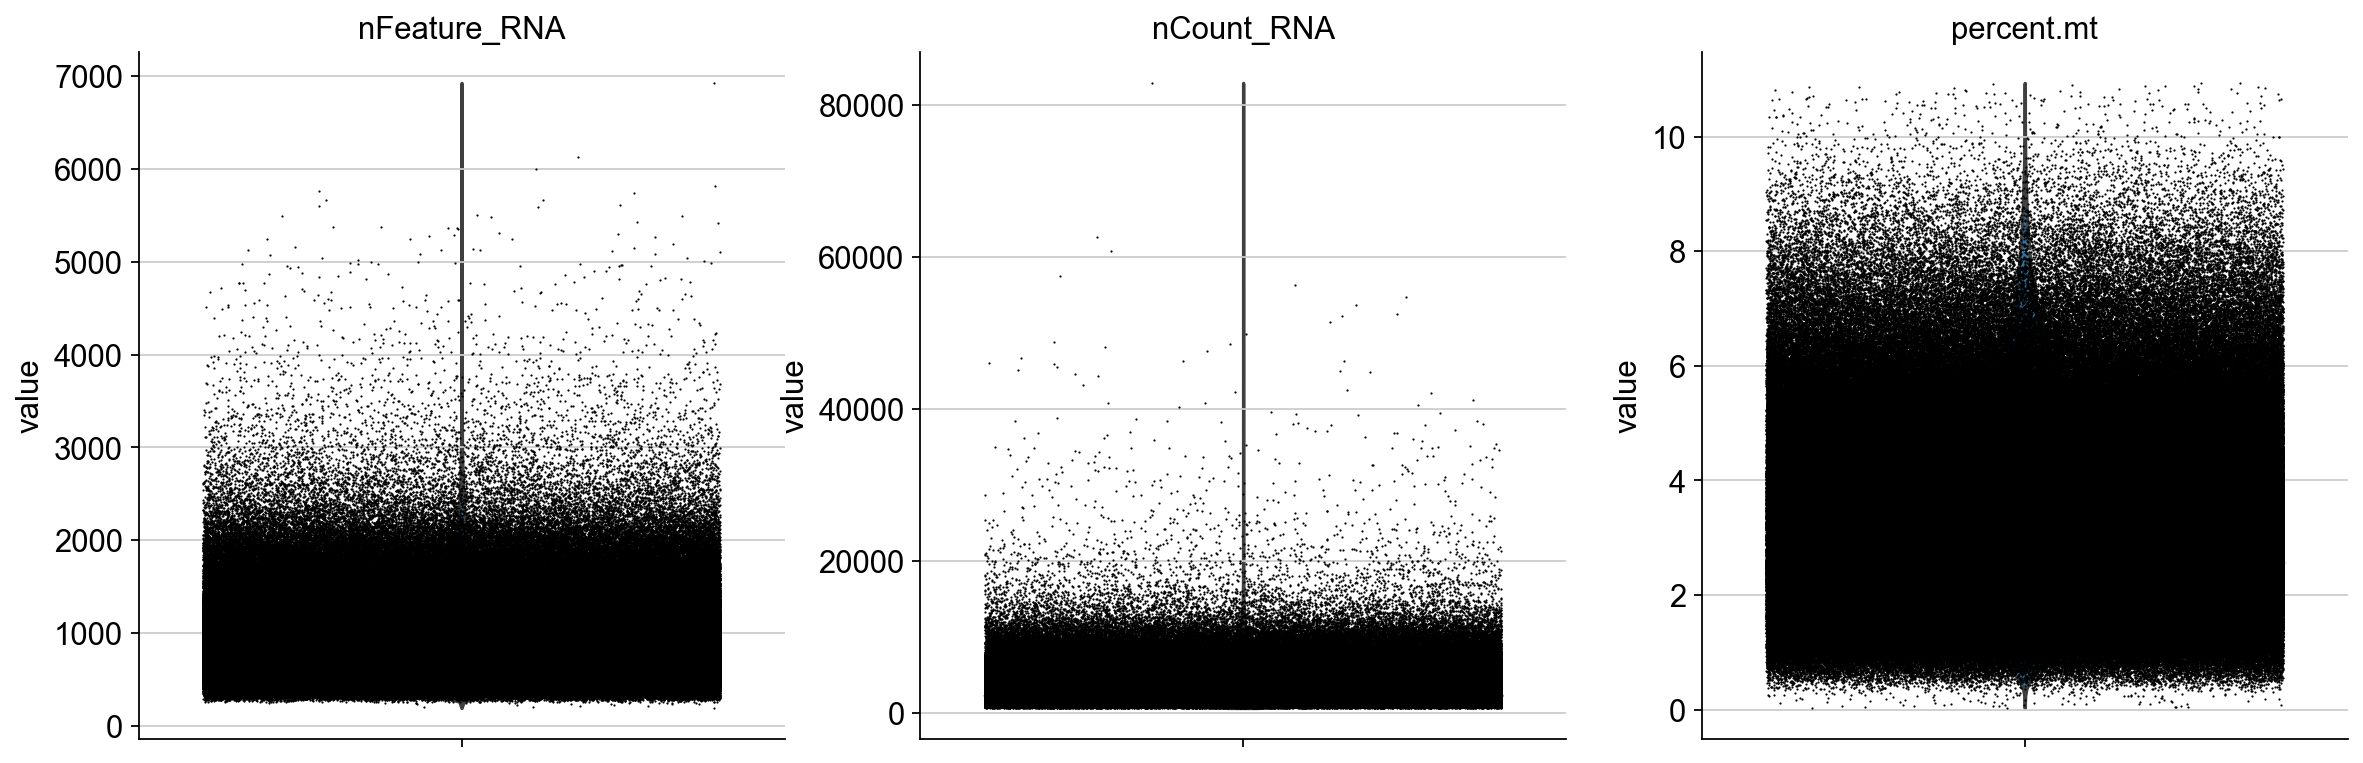

In [37]:
sc.pl.violin(mat, ['nFeature_RNA', 'nCount_RNA', 'percent.mt'],
             jitter=0.4, multi_panel=True)

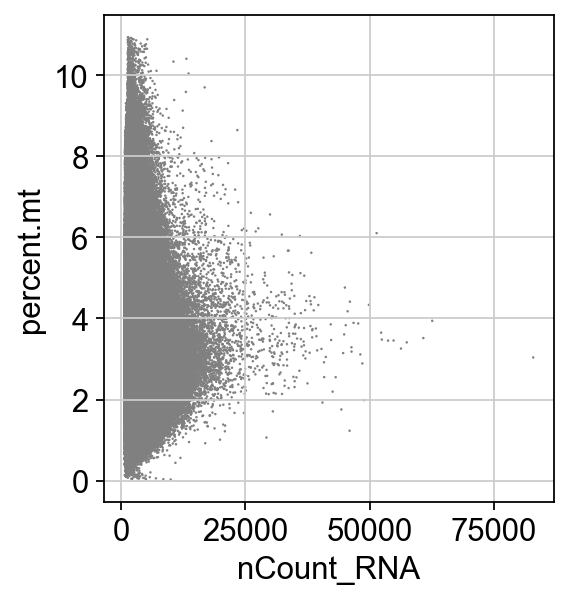

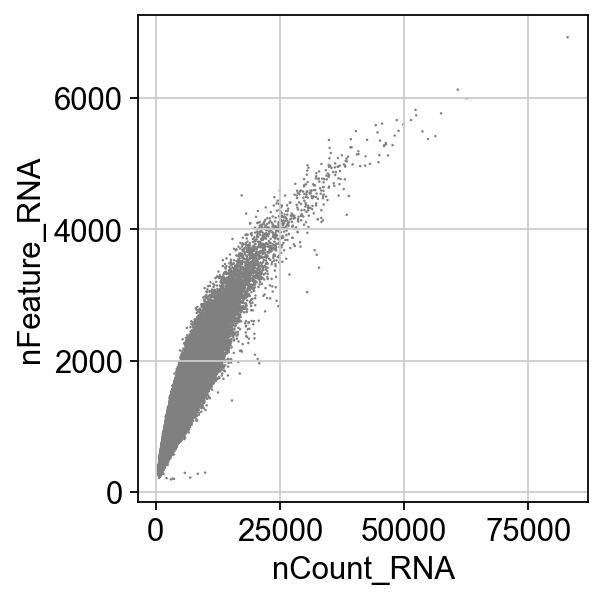

In [38]:
sc.pl.scatter(mat, x='nCount_RNA', y='percent.mt', size = 5)
sc.pl.scatter(mat, x='nCount_RNA', y='nFeature_RNA', size = 5)